In [1]:
import os
import pandas as pd
import imagesize
from PIL import Image
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import dotenv

In [2]:
tqdm.pandas()

In [3]:
DATA_DIR = dotenv.get_key(dotenv.find_dotenv(), "DATA_DIR")

In [4]:
def build_df(data_dir=DATA_DIR):
    splits = os.listdir(data_dir)
    
    df = {
        "path": [],
        "split": [],
        "category": [],
    }
    
    for split in splits:
        split_dir = os.path.join(DATA_DIR, split)
        categories = os.listdir(split_dir)
        for category in categories:
            category_dir = os.path.join(split_dir,category)
            for roi in os.listdir(category_dir):
                roi_path = os.path.join(category_dir, roi)
                df["path"].append(roi_path)
                df["split"].append(split)
                df["category"].append(category)

    df = pd.DataFrame(df)
    df["size"] = df.path.apply(os.path.getsize)
    df["resolution"] = df.path.progress_apply(imagesize.get)
    df["width"] = df["resolution"].apply(lambda x : x[0])
    df["height"] = df["resolution"].apply(lambda x : x[1])
    return df

In [10]:
df = build_df()

Exception ignored in: <function tqdm.__del__ at 0x0000012F93DCB420>
Traceback (most recent call last):
  File "c:\Users\Benya\anaconda3\envs\prj\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\Benya\anaconda3\envs\prj\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [6]:
df.head()

,path,split,category,size,resolution,width,height
0,/home/abdelnour/Downloads/dataset/DL/BRACS_RoI...,test,2_UDH,2573534,"(1169, 781)",1169,781
1,/home/abdelnour/Downloads/dataset/DL/BRACS_RoI...,test,2_UDH,12037631,"(2178, 2072)",2178,2072
2,/home/abdelnour/Downloads/dataset/DL/BRACS_RoI...,test,2_UDH,1814757,"(881, 726)",881,726
3,/home/abdelnour/Downloads/dataset/DL/BRACS_RoI...,test,2_UDH,13038130,"(1963, 2364)",1963,2364
4,/home/abdelnour/Downloads/dataset/DL/BRACS_RoI...,test,2_UDH,2800001,"(1239, 797)",1239,797


<Axes: xlabel='split', ylabel='count'>

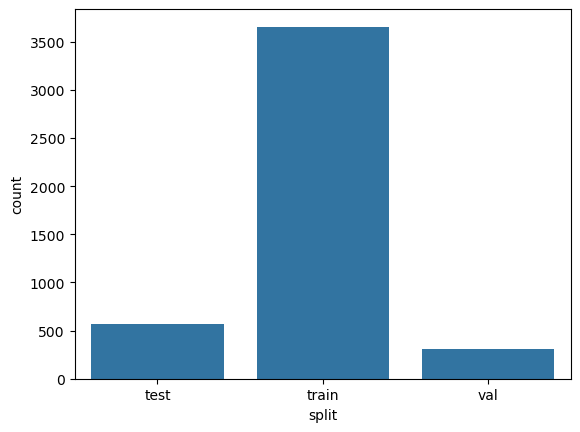

In [8]:
sns.countplot(data=df, x='split')

<Axes: xlabel='category', ylabel='count'>

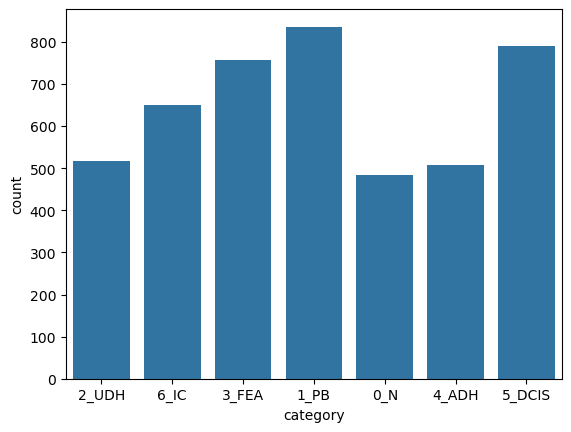

In [9]:
sns.countplot(data=df, x='category')

<Axes: xlabel='category', ylabel='count'>

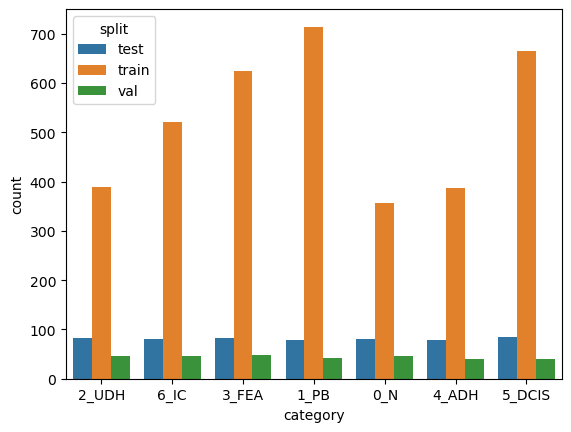

In [10]:
sns.countplot(data=df, x='category', hue='split')

In [12]:
def load_image(infilename) :
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img,dtype="int32")
    return data

In [22]:
test_img = load_image(df.path.iloc[0])

- approach resize to nearest perfect size

In [125]:
def get_new_w_h(w : int,h : int,u_w : int = 224,u_h : int = 224):
    
    n_w = int(np.round(w / u_w).astype(np.int32))
    n_h = int(np.round(h / u_h).astype(np.int32))

    return n_w,n_h

In [128]:
def make_patches(img : np.ndarray, p_w : int = 224, p_h : int = 224):
    
    w, h, c = img.shape
    n_w, n_h = get_new_w_h(w, h, u_w=p_w,u_h=p_h)
    new_w = n_w * p_w
    new_h = n_h * p_h
    resized_img = cv2.resize(test_img, (new_w,new_h), interpolation=cv2.INTER_LINEAR_EXACT)

    n_w = int(new_w / p_w)
    n_h = int(new_h / p_h)

    pacthes = []

    for i in range(n_w):
        pacthes.append([])
        for j in range(n_h):
            pacthes[-1].append(img[i*p_w:(i+1) * p_w,j*p_h:(j+1) * p_h,:])

    return np.array(pacthes)

In [129]:
paches = make_patches(test_img)

In [100]:
def plot_paches(paches):

    fig, axes = plt.subplots(nrows=paches.shape[0],ncols=paches.shape[1])

    i = 0
    j = 0
    
    for row in axes:
        for cell in row:
            cell.imshow(paches[i][j])
            j += 1
        j = 0
        i += 1

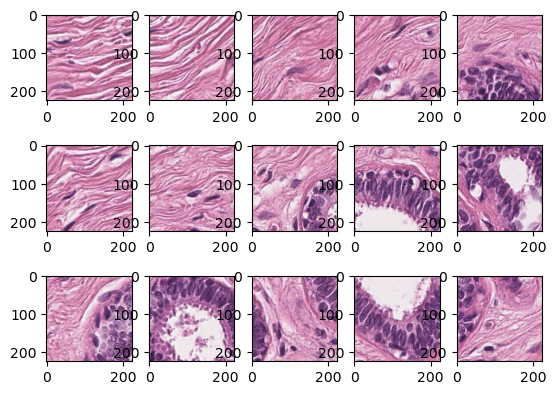

In [130]:
plot_paches(paches)

In [135]:
df['resolution'].progress_apply(lambda res : np.array(get_new_w_h(res[0],res[1])).prod()).sum()

  0%|          | 0/4539 [00:00<?, ?it/s]

404424